<a href="https://colab.research.google.com/github/maty91ok/Licienciatura-Ciencia-de-Datos/blob/main/Final_trabajo_practico_Canevaro_Mat%C3%ADas_v0_0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Final
Versión: v0.0.2

1. Crear la estructura de directorios

In [10]:
import os

# Crear la estructura de directorios
os.makedirs("tp_final/data/interim", exist_ok=True)
os.makedirs("tp_final/data/processed", exist_ok=True)
os.makedirs("tp_final/data/raw", exist_ok=True)

# Comentario: Se crean los directorios necesarios para almacenar los datos en diferentes etapas del procesamiento.

2. Selección del Dataset


In [11]:
import requests

# Descargar el dataset desde Google Drive y guardarlo en tp_final/data/raw
dataset_url = "https://drive.google.com/uc?export=download&id=1CWChGw4K-5CRvEDEc3-HCNKvwvODJZdO"
dataset_path = "tp_final/data/raw/SELECCIONADO-INTERNOS-SPF-CONDENADOS-202403.CSV"

response = requests.get(dataset_url)
with open(dataset_path, 'wb') as file:
    file.write(response.content)

# Documentar el dataset elegido y las razones de su selección
dataset_info = """
Nombre del Dataset: Justicia internos servicio penitenciario federal
URL de Descarga: https://drive.google.com/file/d/1CWChGw4K-5CRvEDEc3-HCNKvwvODJZdO/view
Información: Este dataset contiene información sobre los internos del servicio penitenciario federal, incluyendo datos personales, situación procesal, delitos, penas, etc. Se seleccionó este dataset por su relevancia en el análisis de la justicia y el sistema penitenciario.
"""

# Comentario: Se descarga el dataset desde Google Drive y se guarda en el directorio raw. Se documenta la elección del dataset.

3. Carga de Datos a una Base de Datos


In [16]:
import pandas as pd
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, String, Date, ForeignKey
from sqlalchemy.orm import sessionmaker

# Crear una base de datos utilizando SQLAlchemy
engine = create_engine('sqlite:///tp_final/data/interim/internos.db')
metadata = MetaData()

# Diseñar las tablas necesarias para almacenar los datos del dataset

# Tabla de provincias
provincias_table = Table('provincias', metadata,
    Column('id', Integer, primary_key=True),
    Column('nombre', String)
)

# Tabla de internos
internos_table = Table('internos', metadata,
    Column('id', Integer, primary_key=True),
    Column('unidad', String),
    Column('lpu', Integer),
    Column('apellido', String),
    Column('nombre', String),
    Column('situacion_procesal', String),
    Column('delito', String),
    Column('edad', Integer),
    Column('nacionalidad', String),
    Column('genero', String),
    Column('jurisdiccion', String),
    Column('fecha_sentencia_firme', Date),
    Column('anios_pena', Integer),
    Column('meses_pena', Integer),
    Column('dias_pena', Integer),
    Column('tipo_pena', String),
    Column('estado_civil', String),
    Column('profesion', String),
    Column('subgrupo', String),
    Column('fecha_nacimiento', Date),
    Column('provincia_nacimiento_id', Integer, ForeignKey('provincias.id')),
    Column('unidad_provincia_id', Integer, ForeignKey('provincias.id'))
)

# Crear las tablas en la base de datos
metadata.create_all(engine)

# Cargar los datos del dataset en la base de datos
df = pd.read_csv(dataset_path)

# Extraer y cargar datos de provincias
provincias = pd.concat([df['provincia_nacimiento'], df['unidad_provincia']]).drop_duplicates().dropna().reset_index(drop=True)
provincias_df = pd.DataFrame(provincias, columns=['nombre'])
provincias_df.to_sql('provincias', con=engine, if_exists='append', index=False)

# Mapear nombres de provincias a IDs
provincias_df = pd.read_sql('provincias', con=engine)
provincia_map = provincias_df.set_index('nombre')['id'].to_dict()

# Reemplazar nombres de provincias por IDs en el dataframe original
df['provincia_nacimiento_id'] = df['provincia_nacimiento'].map(provincia_map)
df['unidad_provincia_id'] = df['unidad_provincia'].map(provincia_map)

# Eliminar columnas de nombres de provincias
df = df.drop(columns=['provincia_nacimiento', 'unidad_provincia'])

# Cargar datos de internos
df.to_sql('internos', con=engine, if_exists='append', index=False)

# Comentario: Se crean múltiples tablas en la base de datos SQLite para almacenar los datos del dataset. Se define la estructura de las tablas y las relaciones entre ellas. Luego, se cargan los datos en las tablas correspondientes.

6423

4. Extracción de Datos


In [17]:
# Crear una sesión
Session = sessionmaker(bind=engine)
session = Session()

# Realizar una consulta a la base de datos
query = session.query(internos_table).filter(internos_table.c.delito == 'Contra las Personas')
result = query.all()

# Guardar el resultado de la consulta en un archivo en tp_final/data/interim
result_df = pd.DataFrame(result)
result_df.to_csv("tp_final/data/interim/consulta.csv", index=False)

# Comentario: Se realiza una consulta a la base de datos para obtener un subconjunto de los datos y se guarda el resultado en el directorio interim.

5. Procesamiento del Dataset


In [18]:
# Leer el archivo generado con Pandas
df_interim = pd.read_csv("tp_final/data/interim/consulta.csv")

# Aplicar filtros para eliminar registros del dataset utilizando expresiones regulares
df_filtered = df_interim[df_interim['edad'] > 50]
df_filtered = df_filtered[df_filtered['nacionalidad'].str.contains('Argentina', regex=True)]

# Guardar el dataset procesado en un archivo en tp_final/data/processed
df_filtered.to_csv("tp_final/data/processed/dataset_procesado.csv", index=False)

# Comentario: Se leen los datos del archivo generado en el punto anterior, se aplican filtros para eliminar registros no deseados y se guarda el dataset procesado en el directorio processed.

6. Visualización de Datos


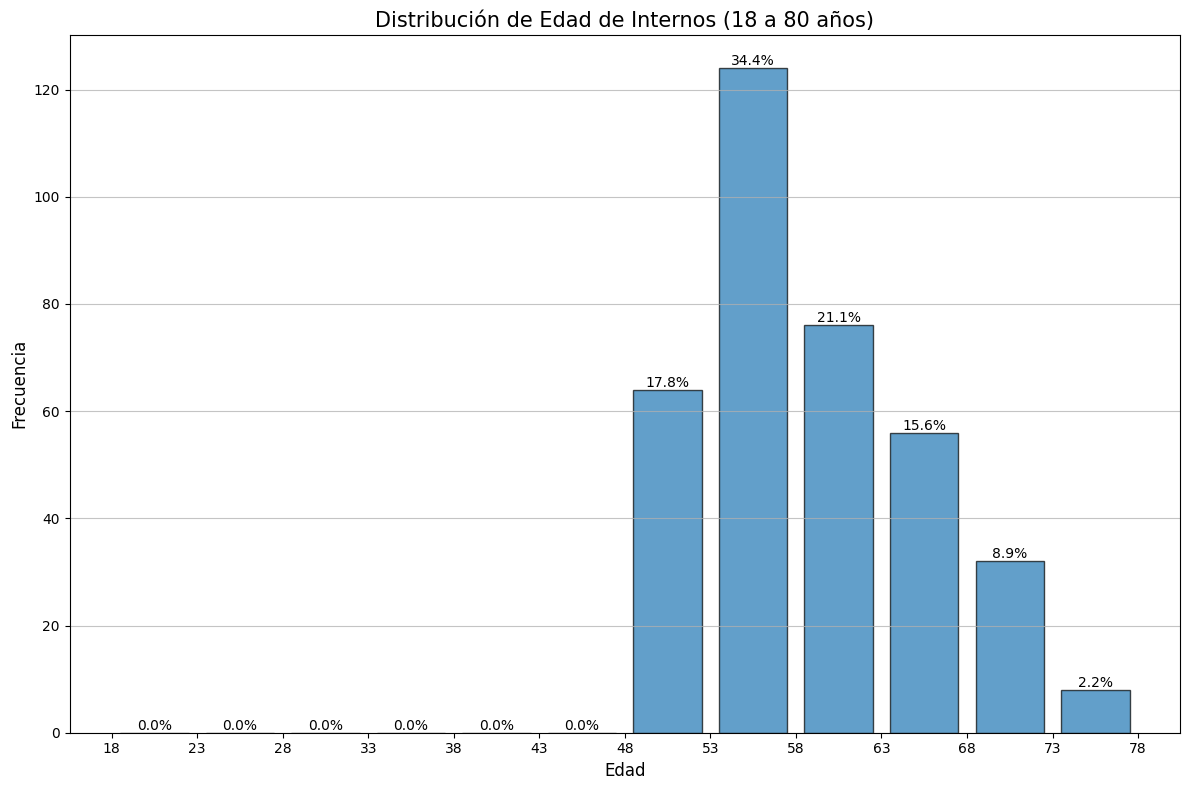

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Filtrar el rango de edad de 18 a 80 años
df_filtered = df_filtered[(df_filtered['edad'] >= 18) & (df_filtered['edad'] <= 80)]

# Calcular la frecuencia y los porcentajes
counts, bins = np.histogram(df_filtered['edad'], bins=np.arange(18, 81, 5))
percentages = counts / counts.sum() * 100

# Crear el gráfico de barras
plt.figure(figsize=(12, 8))
bar_width = 4  # Ancho de las barras
bar_positions = bins[:-1] + (bins[1] - bins[0]) / 2  # Posición de las barras

plt.bar(bar_positions, counts, width=bar_width, edgecolor='black', alpha=0.7)

# Añadir porcentajes encima de las barras
for i in range(len(counts)):
    plt.text(bar_positions[i], counts[i], f'{percentages[i]:.1f}%', ha='center', va='bottom')

plt.title('Distribución de Edad de Internos (18 a 80 años)', fontsize=15)
plt.xlabel('Edad', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.xticks(np.arange(18, 81, 5))
plt.tight_layout()
plt.savefig("tp_final/data/processed/grafico_edad.png")
plt.show()

# Comentario: Se crea un gráfico de barras para visualizar la distribución de la edad de los internos en el rango de 18 a 80 años, incluyendo los porcentajes encima de las barras para una mejor interpretación.